# Notebook for LSTM VAE with word dropout in decoder

# Set up notebook

In [4]:
!nvidia-smi

Fri Jan  3 15:30:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
!pip install sentencepiece

In [6]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
root_path = '/content/drive/My Drive/Colab Notebooks/Sentence_VAE/'
sys.path.append(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import modules

In [0]:
# import model
from modules.model import RNN_VAE, word_dropout

# import loss functions
from modules.loss_functions import ELBO_loss, ELBO_lAnneal, ELBO_cAnneal, ELBO_cAnnealFB, cycAnneal

# import utils
from modules.utils import print_generative_reconstruction, print_reconstruction, plot_loss, get_latent_representation, getActiveUnits

In [0]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import sentencepiece as spm

import pickle
from IPython.display import Image, display, clear_output
import time

# Load data and SentencePiece model (See respective notebooks to see how they are made)

#### Load pickle with preprocessed data

In [0]:
data_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))

In [10]:
print(f"train formal len: {len(data_dict['train']['formal'])}")
print(f"train informal len: {len(data_dict['train']['informal'])}")
print(f"test formal len: {len(data_dict['test']['formal'])}")
print(f"test informal len: {len(data_dict['test']['informal'])}")

train formal len: 12824
train informal len: 12824
test formal len: 582
test informal len: 582


#### Load SentencePiece model

In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'FRtraintest16000.model')
VOCAB_SIZE = 16000

# Setting up model Model

### model

In [0]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64
BATCH_SIZE = 2048
SEQ_LEN = 12 #padded + EOS + SOS
WORD_DROPOUT_P = 0.25

rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN,word_dropout_p = WORD_DROPOUT_P).cuda()

### Data loader

In [0]:
from torch.utils.data import DataLoader
training_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]
test_data_loader = DataLoader(test_data, batch_size=len(test_data))



### Optimizer

In [0]:
optimizer = optim.Adam(rnn_vae.parameters(),lr= 0.0006)

### Training and test functions

In [0]:
def train(epoch):
    rnn_vae.train()
    epoch_loss = 0
    epoch_bce = 0
    epoch_kld = 0
    for index, sentence in enumerate(train_data_loader):
        sentence = torch.LongTensor(sentence)
        sentence = sentence.cuda()
        optimizer.zero_grad()
        output, mu, logvar = rnn_vae.forward(sentence)
        loss, BCE, KLD = ELBO_loss(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_bce += BCE
        epoch_kld += KLD
    epoch_loss /= N_train
    epoch_bce /= N_train
    epoch_kld /= N_train
    return epoch_loss, epoch_bce, epoch_kld


def test(epoch):
    rnn_vae.eval()
    with torch.no_grad(): # No grads needed and we don't want to run out of mem
      epoch_loss = 0
      epoch_bce = 0
      epoch_kld = 0
      for index, sentence in enumerate(test_data_loader):
          sentence = torch.LongTensor(sentence)
          sentence = sentence.cuda()
          output, mu, logvar = rnn_vae.forward(sentence)
          loss, BCE, KLD = ELBO_loss(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=logvar)
          epoch_loss += loss.item()
          epoch_bce += BCE
          epoch_kld += KLD
      epoch_loss /= N_test
      epoch_bce /= N_test
      epoch_kld /= N_test
    return epoch_loss, epoch_bce, epoch_kld

## Training loop

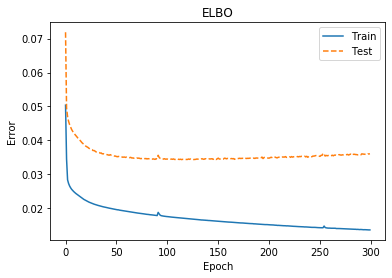

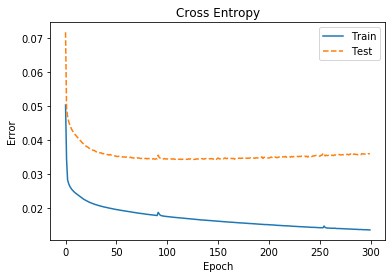

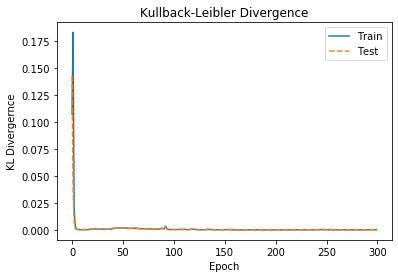

Epoch 299: time: 3.795438051223755
train: loss: 0.013588431695068322 BCE: 0.013588218949735165 KLD: 0.0004156789800617844
test: loss: 0.036054099957967545 BCE: 0.03605368360877037 KLD: 0.0004827636876143515


In [23]:
N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)


train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []
for epoch in range(N_epochs//2):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

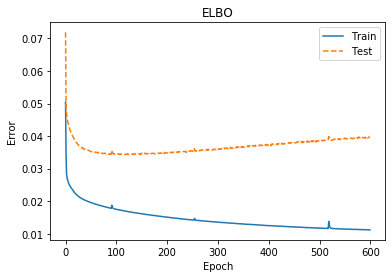

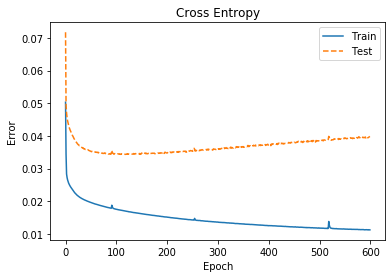

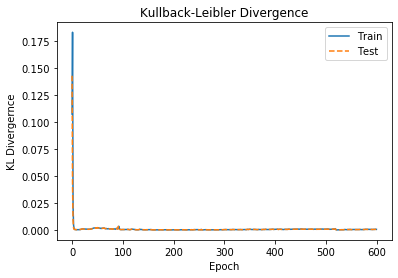

Epoch 599: time: 3.8360843658447266
train: loss: 0.011205581598406796 BCE: 0.011205241084098816 KLD: 0.0006720648962073028
test: loss: 0.0398407572323514 BCE: 0.0398402139544487 KLD: 0.0006346094887703657


In [24]:
for epoch in range(N_epochs//2, N_epochs):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

#### save model

In [0]:
torch.save(rnn_vae.state_dict(), root_path + "trained_models/" + "WD_RNN_VAE_smalldata.pt")

#### Optional load model

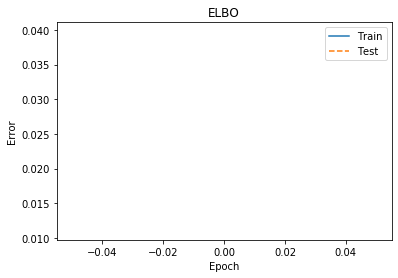

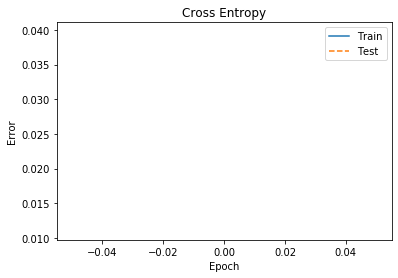

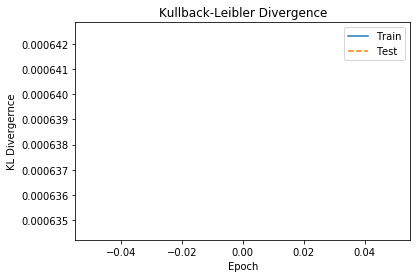

Epoch 0: time: 3.928459644317627
train: loss: 0.01115325660312912 BCE: 0.011152931489050388 KLD: 0.0006424594321288168
test: loss: 0.03966112890604026 BCE: 0.039660584181547165 KLD: 0.0006346094887703657


In [16]:
rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                 latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p = WORD_DROPOUT_P).cuda()

rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "WD_RNN_VAE_smalldata.pt"))

N_train = len(training_data)
N_test = len(test_data)


train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []
for epoch in range(1):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

# Model evaluation

#### ELBO, CBE and KL Divergence of trained model

In [17]:
print(f"ELBO \nTrain: {train_loss_arr[-1]} Test: {test_loss_arr[-1]}")
print(f"Cross Entropy \nTrain: {train_bce_arr[-1]} Test: {test_bce_arr[-1]}")
print(f"KL Divergence \nTrain: {train_kld_arr[-1]} Test: {test_kld_arr[-1]}")

ELBO 
Train: 0.01115325660312912 Test: 0.03966112890604026
Cross Entropy 
Train: 0.011152931489050388 Test: 0.039660584181547165
KL Divergence 
Train: 0.0006424594321288168 Test: 0.0006346094887703657


In [19]:
active_units, test_vars = getActiveUnits(rnn_vae, test_data_loader, delta=0.02)
print(f"Active units: {active_units.cpu().numpy()}")
print(f"Variances: \n{test_vars.cpu().detach().numpy()}")

Active units: 0
Variances: 
[[2.4313353e-05 7.6297047e-06 9.1054217e-06 4.0338808e-05 1.8506042e-05
  1.4480979e-05 3.4712968e-05 2.3696461e-05 2.6396388e-05 1.6820675e-05
  2.9584533e-05 1.6671471e-05 3.0837095e-05 2.4812844e-05 1.8573382e-05
  8.2783990e-06 8.1694634e-06 8.4089315e-06 2.2997308e-05 6.9926441e-06
  1.5290620e-05 1.0571831e-05 1.2877471e-05 5.9712656e-05 1.4301166e-05
  9.3632871e-06 1.3099088e-05 1.7698865e-05 1.9249808e-05 1.4573442e-05
  1.0675940e-05 1.7722903e-05 2.5628466e-05 1.6518825e-05 1.3327178e-05
  7.7595287e-06 6.9650300e-06 3.3959957e-05 1.6233404e-05 1.3810943e-05
  1.4703808e-05 1.5183680e-05 2.7317717e-05 1.3489844e-05 1.8459048e-05
  1.1895899e-05 1.3028472e-05 6.7217770e-06 1.8445910e-05 4.2696338e-06
  3.9079456e-05 1.7324171e-05 1.5923722e-05 2.7250608e-05 1.4253996e-05
  2.2018861e-05 2.7312510e-05 1.0350751e-05 1.1799342e-05 1.5339765e-05
  1.7582883e-05 2.3269371e-05 5.9850081e-06 2.3609524e-05]]


#### reconstructing sentences from training set

In [28]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=train_data_loader)
  print('*******')

Real sentence: then the a****** got her pregnant.
Generated sentence: nobody likes the little finger at all incorrect!

*******
Real sentence: you don't want seconds, do you?
Generated sentence: making out on and look good a trash

*******
Real sentence: i think it's the other way around....
Generated sentence: a vacation for the two of you.

*******
Real sentence: i hope you find your answer very soon!
Generated sentence: i wish you keep going through it though.

*******
Real sentence: they always have diffrent ways of see life.
Generated sentence: depends on the girl charcter

*******
Real sentence: no, i like to kiss girl
Generated sentence: go at the the bar i dont tell!

*******
Real sentence: nice, good luck and do not chicken out.
Generated sentence: cuz they always want what they can't.

*******
Real sentence: i was not sure if i was.
Generated sentence: i do u know what u want it!

*******
Real sentence: it sounds like she needs to let go.
Generated sentence: why would you wan

#### reconstructing sentences from test set

In [29]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=test_data_loader)
  print('*******')

Real sentence: are you posing a rhetorical question?
Generated sentence: i suppose that is the first step.

*******
Real sentence: i do not intend to be mean.
Generated sentence: lose your pants on until your face itself.

*******
Real sentence: ask him if you should go see a doctor.
Generated sentence: you know it is better.

*******
Real sentence: also, i would like to try again.
Generated sentence: he loves you more than that.

*******
Real sentence: women are coomplicated.
Generated sentence: i wonder i have at an amazing woman.

*******
Real sentence: doing that does sound rather feminine.
Generated sentence: you definitely need to begin by ceasing communications.

*******
Real sentence: do i desire to be in love?
Generated sentence: currently, i am very lucky, answer yes.

*******
Real sentence: that is if you truly adore them.
Generated sentence: do you consider yourself in a future.

*******
Real sentence: you should never allow a man to mistreat you.
Generated sentence: appare